# Computational Biology Exercise
### Predicting Lapatinib IC50 Response with Cell Line Clinical and Expression data

In [1]:
import numpy as np
import pandas as pd
import os, sys, json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import cross_validate, KFold

In [2]:
# load data

expression_df = pd.read_csv('data/CCLE_expression.csv', index_col=0)
metadata_df = pd.read_excel('data/sample_info.xlsx', index_col=0)
drug_df = pd.read_csv('data/GDSC2_fitted_dose_response_25Feb20(Sheet 1).csv', index_col=0)

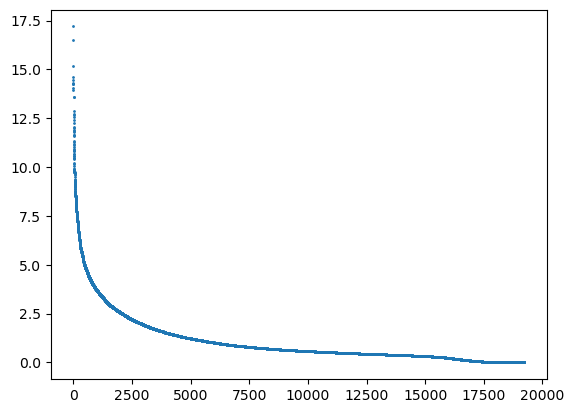

In [3]:
# process expression data and get high variance genes

expression_df.columns = expression_df.columns.map(lambda x:x.split('(')[0].strip(' '))
gene_variance = expression_df.var(axis=0).sort_values(ascending=False)

plt.figure()
plt.scatter(y=gene_variance, x=np.arange(len(gene_variance)), s=1)
plt.show()
#  top 3000 features may be descriptive enough as it is past the inflection point - use this cutoff for feature selection
gene_features = gene_variance.iloc[:3000].index.to_list()

In [4]:
# override and use all 20k genes

# gene_features = gene_variance.iloc[:].index.to_list()

In [5]:
# metadata/clinical data processing

metadata_features = ['sex', 'age', 'source', 'sample_collection_site' ,'primary_or_metastasis', 'primary_disease', 'lineage', 'lineage_molecular_subtype', 'culture_type']
cell_line_ids = ['DepMap_ID', 'cell_line_name', 'stripped_cell_line_name', 'CCLE_Name']

sample_ids = expression_df.index.intersection(metadata_df.index)
cell_line_names = metadata_df.loc[sample_ids, 'stripped_cell_line_name'].to_list()

In [6]:
# transform, one hot encode, reduce sparsity

metadata_df['culture_type'] = metadata_df['culture_type'].replace({'Loosely Adherent':'Adherent', 'S&A':'Mixed adherent and suspension', 'Mix':'Mixed', 
       'Mix (loosely adherent with floating clumps)':'Mixed',
       'Adherent and floating viable cells':'Adherent'}).fillna('not found').str.lower()


metadata_df['lineage'] = metadata_df['lineage'].replace(['engineered_bone', 'embryo', 'engineered_kidney', 'engineered_breast',
       'engineered_prostate', 'engineered_lung', 'engineered_ovary',
       'engineered_central_nervous_system', 'adrenal_cortex',
       'epidermoid_carcinoma', 'engineered_blood'], 'rare_site').fillna('unknown').str.lower()


metadata_df['sample_collection_site'] = metadata_df['sample_collection_site'].replace(['eye','prostate','uvea','pleura', 'pericardial_effusion',
                                              'engineered','spleen','Embryonal','small_intestine','Placenta',
                                              'salivary_gland','Testes'], 'rare_sites').fillna('unknown').str.lower()

metadata_df.loc[metadata_df['age'].isnull(), 'age_missing'] = 1
metadata_features.append('age_missing')
metadata_df.loc[metadata_df['age'].isnull(), 'age'] = metadata_df['age'].median()
metadata_df['age_missing'].fillna(0, inplace=True)

metadata_df['primary_or_metastasis'] = metadata_df['primary_or_metastasis'].fillna('unkonwn').str.lower()

metadata_df['sex'] = metadata_df['sex'].fillna('unkonwn').str.lower()

metadata_df['primary_disease'] = metadata_df['primary_disease'].replace(' ', '_', regex=True).fillna('unknown').str.lower()

/var/folders/_4/9nrs715j24b57wtj2r5vhzz80000gn/T/ipykernel_81853/1423653759.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_df['age_missing'].fillna(0, inplace=True)


In [7]:
# process drug data and select lapatinib

gdsc_features = ['DRUG_NAME', 'TCGA_DESC', 'PUTATIVE_TARGET', 'PATHWAY_NAME']
gdsc_response = ['MIN_CONC','MAX_CONC','LN_IC50','AUC','RMSE','Z_SCORE']

cell_line_id2name_mapper = dict(zip(metadata_df.index, metadata_df.stripped_cell_line_name))
cell_line_name2id_mapper = dict(zip(metadata_df.stripped_cell_line_name, metadata_df.index))

drug_df['STRIPPED_CELL_LINE_NAME'] = drug_df['CELL_LINE_NAME'].str.replace('-', '', regex=False).str.strip().str.upper()
drug_df['DepMap_ID'] = drug_df['STRIPPED_CELL_LINE_NAME'].map(cell_line_name2id_mapper)

lapatinib_drug_data = drug_df.loc[drug_df['DRUG_NAME']=='Lapatinib'].copy()
lapatinib_drug_data = lapatinib_drug_data.loc[lapatinib_drug_data['STRIPPED_CELL_LINE_NAME'].isin(cell_line_names)]

lapatinib_drug_data = lapatinib_drug_data.drop_duplicates(subset='DepMap_ID', keep='first')


In [8]:
# lapatinib_drug_data2 = drug_df.loc[(drug_df['DRUG_NAME']=='Lapatinib') | (drug_df['DRUG_NAME']=='lapatinib')].copy()
# # lapatinib_drug_data2['CELL_LINE_NAME'] = lapatinib_drug_data2['CELL_LINE_NAME'].str.strip('-/., ').str.upper()
# lapatinib_drug_data2 = lapatinib_drug_data2.loc[lapatinib_drug_data2['STRIPPED_CELL_LINE_NAME'].isin(cell_line_names)]

# lapatinib_drug_data = drug_df.loc[drug_df['DRUG_NAME']=='Lapatinib'].copy()
# lapatinib_drug_data = lapatinib_drug_data.loc[lapatinib_drug_data['STRIPPED_CELL_LINE_NAME'].isin(cell_line_names)]

In [9]:
# curiosity - lapatinib's mechanism of action is through ERBB2/EGFR signalling. does ERBB2/EGFR expression correlate with lapatinib sensitivity in these cell lines?

corr_df = pd.merge(lapatinib_drug_data[['DepMap_ID'] + gdsc_response], 
          expression_df[['ERBB2', 'EGFR']].reset_index().rename(columns={'index':'DepMap_ID'}), on='DepMap_ID')

# first let us check if ERBB2 and EGFR expression have a correlation with the lapatinib drug sensitivity metrics
import scipy.stats as stats

print('ERBB2 x LN 1C50, r =', stats.pearsonr(corr_df['ERBB2'], corr_df['LN_IC50'])[0], 'p = ', stats.pearsonr(corr_df['ERBB2'], corr_df['LN_IC50'])[1])
print('ERBB2 x AUC, r =', stats.pearsonr(corr_df['ERBB2'], corr_df['AUC'])[0], 'p = ', stats.pearsonr(corr_df['ERBB2'], corr_df['AUC'])[1])
print('EGFR x LN 1C50, r =', stats.pearsonr(corr_df['EGFR'], corr_df['LN_IC50'])[0], 'p = ', stats.pearsonr(corr_df['EGFR'], corr_df['LN_IC50'])[1])
print('EGFR x AUC, r =', stats.pearsonr(corr_df['EGFR'], corr_df['AUC'])[0], 'p = ', stats.pearsonr(corr_df['EGFR'], corr_df['AUC'])[1])

ERBB2 x LN 1C50, r = -0.12902980770083294 p =  0.0021777146222380153
ERBB2 x AUC, r = -0.3902495205898829 p =  6.9291966740568e-22
EGFR x LN 1C50, r = 0.12615676080026306 p =  0.0027349266992749595
EGFR x AUC, r = -0.0972748932890104 p =  0.021088926199491487


- there is some negative correlation between ERBB2  expression and lapatinib sensitivity metrics (LN_IC50 and AUC)
- however EGFR expression does not show any correlation with lapatinib sensitivity
- next let us build a model to predict lapatinib sensitivity using gene expression data, without solely relying on ERBB2/EGFR

In [10]:
sample_ids_w_drug = sample_ids.intersection(set(lapatinib_drug_data['DepMap_ID']))

In [11]:
# clinical vars
clinical_mtx = pd.get_dummies(metadata_df.loc[sample_ids_w_drug, [
    'sex','age','age_missing', 'primary_or_metastasis','primary_disease','sample_collection_site', 'lineage','culture_type']], dtype='int')
clinical_mtx.drop(clinical_mtx.loc[:, (clinical_mtx.sum() < 5)].columns.to_list(), axis=1, inplace=True)

clinical_mtx2 = clinical_mtx.loc[:, ~(clinical_mtx.columns.str.startswith('sample_collection') | 
                      (clinical_mtx.columns.str.startswith('lineage')))]

# expression
expression_mtx = expression_df.loc[sample_ids_w_drug, gene_features]

# drug
lapatinib_mtx = lapatinib_drug_data.loc[lapatinib_drug_data['DepMap_ID'].isin(sample_ids_w_drug), ['DepMap_ID'] + gdsc_response].set_index('DepMap_ID')

In [12]:
X = pd.concat([clinical_mtx, expression_mtx], axis=1).loc[sample_ids_w_drug]

y = lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug]
# y_scaled = StandardScaler().fit_transform(lapatinib_mtx.loc[sample_ids_w_drug, ['LN_IC50']]).ravel()

X_data = np.asarray(X)
y_data = np.asarray(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=101)
print('cell lines x features:   ' , X_train.shape, X_test.shape)

cell lines x features:    (421, 3084) (141, 3084)


In [13]:
# initialise and train XGBRegressor

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.2,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=101,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predictions on test set
y_pred_test = model.predict(X_test)

# Calculate test metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = np.mean(np.abs(y_test - y_pred_test))

print("-" * 60)
print("TEST SET DETAILED RESULTS")
print("-" * 60)
print(f"MSE:   {mse_test:.4f}")
print(f"RMSE:  {rmse_test:.4f}")
print(f"MAE:   {mae_test:.4f}")
print(f"r-squared:    {r2_test:.4f}")
print(f"N samples: {len(y_test)}")

# cross-validation k=5
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_ic50 = cross_validate(
    model, X_data, y_data, cv=cv,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_rmse = np.sqrt(-cv_results_ic50['test_neg_mean_squared_error'])
cv_r2 = cv_results_ic50['test_r2']

print("\n" + "-" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("-" * 60)
print(f"RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
print(f"r-squared:   {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print("\nPer-fold RMSE:", [f"{x:.4f}" for x in cv_rmse])
print("Per-fold r-squared:  ", [f"{x:.4f}" for x in cv_r2])

------------------------------------------------------------
TEST SET DETAILED RESULTS
------------------------------------------------------------
MSE:   2.7031
RMSE:  1.6441
MAE:   1.3148
r-squared:    0.1371
N samples: 141

------------------------------------------------------------
5-FOLD CROSS-VALIDATION RESULTS
------------------------------------------------------------
RMSE: 1.4513 (+/- 0.0910)
r-squared:   0.2026 (+/- 0.0350)

Per-fold RMSE: ['1.4340', '1.3846', '1.4624', '1.3575', '1.6178']
Per-fold r-squared:   ['0.1734', '0.1923', '0.1694', '0.2655', '0.2125']


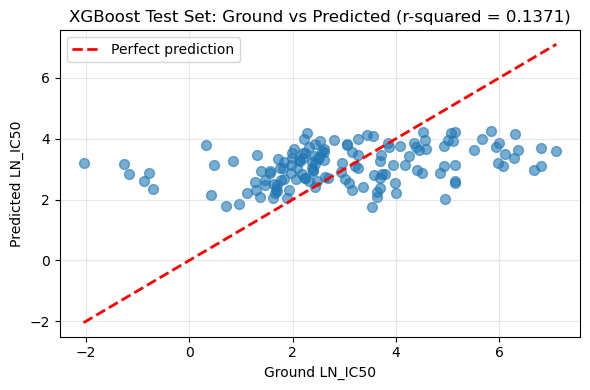

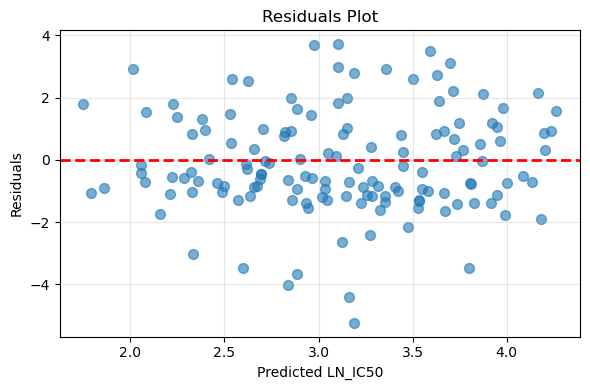

In [14]:
# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Ground LN_IC50')
plt.ylabel('Predicted LN_IC50')
plt.title(f'XGBoost Test Set: Ground vs Predicted (r-squared = {r2_test:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted LN_IC50')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

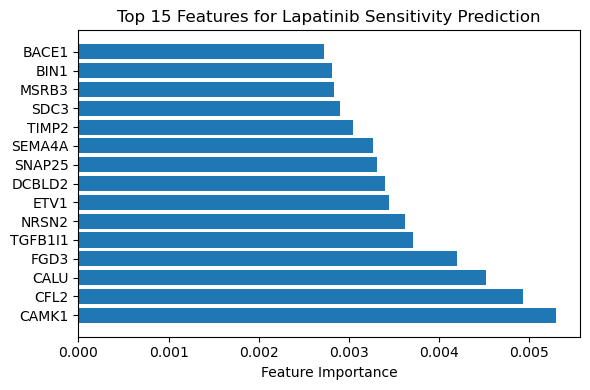

In [15]:
# Feature importance
feature_importance_ic50 = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


# Plot top features
plt.figure(figsize=(6, 4))
top_features = feature_importance_ic50.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 15 Features for Lapatinib Sensitivity Prediction')
plt.tight_layout()
plt.show()

- the model produces a stable result (r2 ~ 0.15), however, despite of only selecting high-variance genes, the model still underfits due to noisy expression data. 
- to improve this, we will identify if it is possible to reduce the dimensionality using the following methods (1) biological improvement - GSVA pathways or ERBB/EGFR pathways (2) embeddings form autoencoders

In [16]:
correlations_with_ic50 = pd.DataFrame(index=gene_features, columns=['pearson_r', 'p_value'])

for i in gene_features:
    r, p = stats.pearsonr(expression_df.loc[sample_ids_w_drug, i], lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug])
    correlations_with_ic50.loc[i, 'pearson_r'] = r
    correlations_with_ic50.loc[i, 'p_value'] = p

correlated_genes = correlations_with_ic50.loc[(correlations_with_ic50['pearson_r'].abs() >= 0.15) & 
                           (correlations_with_ic50['p_value'] < 0.05)].sort_values('pearson_r', ascending=False).index.to_list()

In [17]:
# (1) biological improvement - GSVA feature engineering
import gseapy as gp
import json
from pathlib import Path

def load_gene_sets(path: Path):
    if path.suffix == '.json':
        with open(path) as f:
            js = json.load(f)
        # handle json layouts
        if isinstance(js, dict):
            return {k: v.get('geneSymbols', v) if isinstance(v, dict) else v for k, v in js.items()}
        if isinstance(js, list):
            return {item.get('name', f'gs_{i}'): item.get('geneSymbols', item.get('genes', []))
                    for i, item in enumerate(js)}
    elif path.suffix == '.gmt':
        gs = {}
        with open(path) as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    gs[parts[0]] = parts[2:]
        return gs
    else:
        raise FileNotFoundError(f"Unsupported gene set file: {path}")


# prepare expression - genes x samples
expr_mat = expression_df.loc[sample_ids_w_drug].copy()
expr_mat = expr_mat.T.astype(float)

h_gene_set_path = Path('/Users/shrutishikhare/Documents/Coding/datasets/genesets/h.all.v2022.1.Hs.json')
c6_gene_set_path = Path('/Users/shrutishikhare/Documents/Coding/datasets/genesets/c6.all.v2022.1.Hs.json')

h_gene_sets = load_gene_sets(h_gene_set_path)
c6_gene_sets = load_gene_sets(c6_gene_set_path)

# merge both together
merged_gene_sets = {k: v for k, v in h_gene_sets.items()}
merged_gene_sets.update({f"ONCOGENIC_{k}": v for k, v in c6_gene_sets.items()})

# run GSVA
gsva_res = gp.gsva(data=expr_mat, gene_sets=merged_gene_sets, outdir='gsva_out', min_size=10, max_size=500,
                   method='gsva', verbose=True, processes=4)

gsva_scores = gsva_res.res2d
# gsva_scores.to_csv('gsva_out/gsva_scores.csv')
gsva_scores['Term'] = gsva_scores['Term'].replace({'0__': np.nan, '1__':'ONCOGENIC_'}, regex=True)
gsva_df = pd.pivot_table(gsva_scores, index='Name', columns='Term', values='ES').astype(float)

2026-01-01 03:27:43,121 [INFO] Parsing data files for GSVA.............................
2026-01-01 03:27:43,167 [INFO] Estimating ECDFs with Gaussian kernels.
2026-01-01 03:27:43,183 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=10
2026-01-01 03:27:43,184 [INFO] 0239 gene_sets used for further statistical testing.....
2026-01-01 03:27:43,184 [INFO] Start to run GSVA...Might take a while................
2026-01-01 03:27:57,305 [INFO] Done


In [18]:
# (1) biological improvement - MSIGDB oncogenic and hallmark gene sets

with open('/Users/shrutishikhare/Documents/Coding/datasets/genesets/c6.all.v2022.1.Hs.json') as f:
    msigdb_oncogenic = json.load(f)
msigdb_oncogenic = {k:i['geneSymbols'] for k, i in msigdb_oncogenic.items()}

with open('/Users/shrutishikhare/Documents/Coding/datasets/genesets/h.all.v2022.1.Hs.json') as f:
    msigdb_hallmark = json.load(f)
msigdb_hallmark = {k:i['geneSymbols'] for k, i in msigdb_hallmark.items()}

# PI3K/Akt/mTOR and the MAPK/ERK are important in the mechanism of action of ERBB2 and EGFR targetting drugs like lapatinib
# incorporating biology from the following msigdb hallmark and oncogenic pathways:

lapatinib_relevant_pathways = [
    "HALLMARK_EGF_RESPONSE","HALLMARK_PI3K_AKT_MTOR_SIGNALING","HALLMARK_MTORC1_SIGNALING",
    "HALLMARK_KRAS_SIGNALING_UP","HALLMARK_MAPK_SIGNALING", "HALLMARK_MYC_TARGETS_V1","HALLMARK_E2F_TARGETS", 
    "HALLMARK_G2M_CHECKPOINT", "EGFR_UP.V1_UP","ERBB2_UP.V1_UP", "KRAS.600_UP.V1_UP", "PI3K_AKT_MTOR_UP.V1_UP", 
    "MYC_UP.V1_UP", "AKT_UP.V1_UP"
]

# selecting the genes that belong to the pathways above. these should be included in the expression features used for model training
msigdb_genes = list(set(pd.DataFrame([i for k, i in msigdb_oncogenic.items() if k in lapatinib_relevant_pathways]).melt().value.unique().tolist() + \
pd.DataFrame([i for k, i in msigdb_hallmark.items() if k in lapatinib_relevant_pathways]).melt().value.unique().tolist()))

In [19]:
correlations_with_ic50_pathways = pd.DataFrame(index=gsva_df.columns.to_list(), columns=['pearson_r', 'p_value'])

for i in gsva_df.columns.to_list():
    r, p = stats.pearsonr(gsva_df.loc[sample_ids_w_drug, i], lapatinib_mtx.loc[sample_ids_w_drug, 'LN_IC50'])
    correlations_with_ic50_pathways.loc[i, 'pearson_r'] = r
    correlations_with_ic50_pathways.loc[i, 'p_value'] = p

correlated_pathways = correlations_with_ic50_pathways.loc[(correlations_with_ic50_pathways['pearson_r'].abs() >= 0.1) & 
                           (correlations_with_ic50_pathways['p_value'] < 0.05)].sort_values('pearson_r', ascending=False).index.to_list()

In [20]:
# feature selection
 
# gene_features = list(set(gene_features + msigdb_genes).intersection(expression_df.columns))
refined_gene_features = list(set(gene_features) & set(correlated_genes)) # | (set(msigdb_genes).intersection(set(expression_df.columns))))

expression_mtx = expression_df.loc[sample_ids_w_drug, refined_gene_features]

lapatinib_relevant_pathways = [
    "HALLMARK_EGF_RESPONSE","HALLMARK_PI3K_AKT_MTOR_SIGNALING","HALLMARK_MTORC1_SIGNALING",
    "HALLMARK_KRAS_SIGNALING_UP","HALLMARK_MAPK_SIGNALING", "HALLMARK_MYC_TARGETS_V1", "HALLMARK_MYC_TARGETS_V2","HALLMARK_E2F_TARGETS", 
    "HALLMARK_G2M_CHECKPOINT", "ONCOGENIC_EGFR_UP.V1_UP","ONCOGENIC_ERBB2_UP.V1_UP", "ONCOGENIC_KRAS.600_UP.V1_UP", "ONCOGENIC_PI3K_AKT_MTOR_UP.V1_UP", 
    "ONCOGENIC_MYC_UP.V1_UP", "ONCOGENIC_AKT_UP.V1_UP"
]

gsva_mtx = gsva_df.loc[sample_ids_w_drug]
# gsva_mtx = gsva_mtx.loc[:, gsva_mtx.columns.isin(lapatinib_relevant_pathways)]

In [21]:
# (2) dimensionality reduction - UMAP on expression data and/or autoencoders

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

seed = 101

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class MultiModalAutoencoder(nn.Module):
    def __init__(self,clin_dim, expr_dim, gsva_dim, bottleneck_clin=8, bottleneck_expr=64, bottleneck_gsva=16, dropout=0.2):
        super(MultiModalAutoencoder, self).__init__()

        # clinical encoder
        self.clin_encoder = nn.Sequential(
            nn.Linear(clin_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_clin)
        )
        
        # expression encoder
        self.expr_encoder = nn.Sequential(
            nn.Linear(expr_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_expr)
        )
        
        # gsva pathways encoder
        self.gsva_encoder = nn.Sequential(
            nn.Linear(gsva_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, bottleneck_gsva)
        )

        # joint bottleneck
        self.bottleneck_dim = bottleneck_clin + bottleneck_expr + bottleneck_gsva
        
        # clinical decoder
        self.clin_decoder = nn.Sequential(
            nn.Linear(bottleneck_clin, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, clin_dim)
        )
        
        # expression decoder
        self.expr_decoder = nn.Sequential(
            nn.Linear(bottleneck_expr, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, expr_dim)
        )

        # gsva pathways decoder
        self.gsva_decoder = nn.Sequential(
            nn.Linear(bottleneck_gsva, 32),
            nn.ReLU(),
            nn.Linear(32, gsva_dim)
        )

    def forward(self, x_clin, x_expr, x_gsva):
        # encoding modalities separately
        z_clin = self.clin_encoder(x_clin)
        z_expr = self.expr_encoder(x_expr)
        z_gsva = self.gsva_encoder(x_gsva)
        
        # concatenate the bottlenck representations
        z_joint = torch.cat([z_clin, z_expr, z_gsva], dim=1)
        
        # decode separately
        x_clin_hat = self.clin_decoder(z_clin)
        x_expr_hat = self.expr_decoder(z_expr)
        x_gsva_hat = self.gsva_decoder(z_gsva)
        
        return x_clin_hat, x_expr_hat, x_gsva_hat, z_joint


#### train
def train_autoencoder(model, clin_tensor, expr_tensor, gsva_tensor,
                         epochs=300, batch_size=32, lr=1e-3,
                         weight_clin=3, weight_expr=6, weight_gsva=5):

    # training a multimodal autoencoder with a weighted reconstruction loss

    # preparing data, loading optimisers
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.MSELoss()
    
    dataset = torch.utils.data.TensorDataset(clin_tensor, expr_tensor, gsva_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x_clin, x_expr, x_gsva = batch
            optimizer.zero_grad()
            
            x_clin_hat, x_expr_hat, x_gsva_hat, _ = model(x_clin, x_expr, x_gsva)
            
            # Weighted MSE
            loss_clin = criterion(x_clin_hat, x_clin)
            loss_expr = criterion(x_expr_hat, x_expr)
            loss_gsva = criterion(x_gsva_hat, x_gsva)
            
            loss = weight_clin*loss_clin + weight_expr*loss_expr + weight_gsva*loss_gsva
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_clin.size(0)
        
        total_loss /= len(clin_tensor)
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Loss = {total_loss:.4f}")


In [22]:
clinical_mtx2 = clinical_mtx.loc[:, ~((clinical_mtx.columns.str.startswith('primary_disease')) |
                                      (clinical_mtx.columns.str.startswith('sample_collection')))]

In [23]:
import scipy.stats as stats

clin_scaled = StandardScaler().fit_transform(clinical_mtx2)

expr_scaled = StandardScaler().fit_transform(expression_mtx)

gsva_scaled = StandardScaler().fit_transform(gsva_mtx)
# expr_scaled = expression_mtx.apply(stats.zscore).values

clin_tensor = torch.tensor(clin_scaled, dtype=torch.float32)
expr_tensor = torch.tensor(expr_scaled, dtype=torch.float32)
gsva_tensor = torch.tensor(gsva_scaled, dtype=torch.float32)


model = MultiModalAutoencoder(clin_dim=clin_tensor.shape[1], expr_dim=expr_tensor.shape[1], gsva_dim=gsva_tensor.shape[1])
train_autoencoder(model, clin_tensor, expr_tensor, gsva_tensor, epochs=300)

Epoch 000 | Loss = 13.1876
Epoch 020 | Loss = 6.2378
Epoch 040 | Loss = 5.1347
Epoch 060 | Loss = 4.5896
Epoch 080 | Loss = 4.1994
Epoch 100 | Loss = 3.9427
Epoch 120 | Loss = 3.7535
Epoch 140 | Loss = 3.5904
Epoch 160 | Loss = 3.5193
Epoch 180 | Loss = 3.3982
Epoch 200 | Loss = 3.3465
Epoch 220 | Loss = 3.2866
Epoch 240 | Loss = 3.2126
Epoch 260 | Loss = 3.1658
Epoch 280 | Loss = 3.1112


In [24]:
# evaluate model embeddings

model.eval()
with torch.no_grad():
    _, _, _, z_joint = model(clin_tensor, expr_tensor, gsva_tensor)
    Z = z_joint.cpu().numpy()
X_AE_embeddings = pd.DataFrame(Z, index=sample_ids_w_drug, columns=[f'AE_latent_{i}' for i in range(Z.shape[1])])
# X_AE_embeddings.to_csv('AE_latent_embeddings.csv')

In [25]:
import umap
import matplotlib.pyplot as plt

u = umap.UMAP(n_components=2, random_state=101)
emb2d_raw = u.fit_transform(X_data)
emb2d_ae = u.fit_transform(X_AE_embeddings.values)

/opt/anaconda3/envs/torch-clean/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


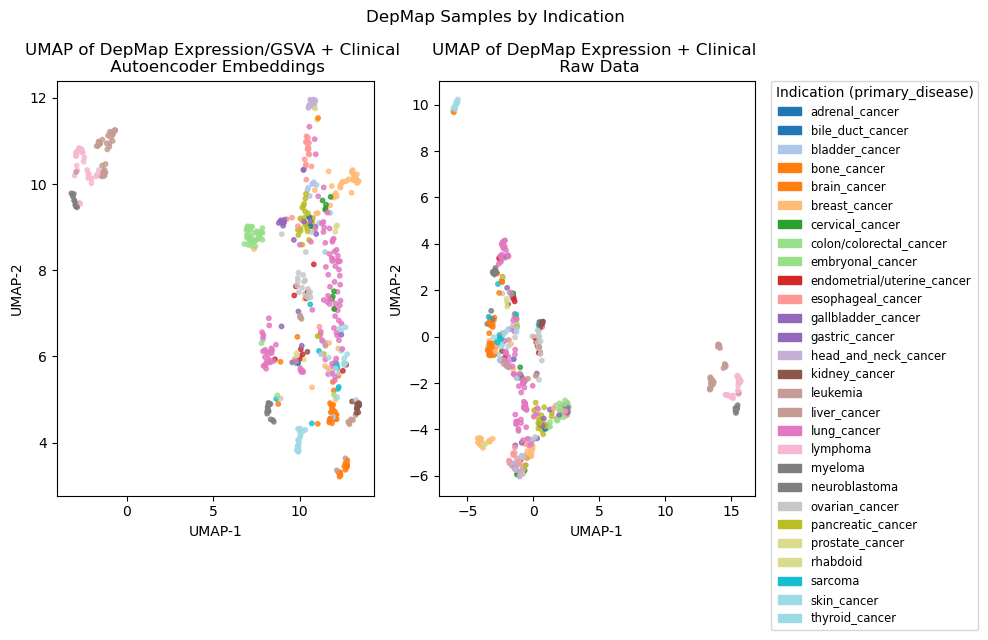

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
import matplotlib.patches as mpatches
lineage = metadata_df.loc[sample_ids_w_drug, 'primary_disease']

unique_types = np.unique(lineage)
type_to_code = {t: i for i, t in enumerate(unique_types)}
codes = np.array([type_to_code[t] for t in lineage])

# Choose a colormap with enough colors
colormap = plt.get_cmap('tab20') if len(unique_types) > 9 else plt.get_cmap('Set1')

sc0 = axes[0].scatter(emb2d_ae[:,0], emb2d_ae[:,1], s=10, c=codes, cmap=colormap, alpha=0.8)
axes[0].set_title("UMAP of DepMap Expression/GSVA + Clinical \n Autoencoder Embeddings")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

sc1 = axes[1].scatter(emb2d_raw[:,0], emb2d_raw[:,1], s=10, c=codes, cmap=colormap, alpha=0.8)
axes[1].set_title("UMAP of DepMap Expression + Clinical \n Raw Data")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Create legend
handles = [mpatches.Patch(color=colormap(type_to_code[t]/max(len(unique_types)-1,1)), label=t) for t in unique_types]
axes[1].legend(handles=handles, title="Indication (primary_disease)", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')

plt.suptitle("DepMap Samples by Indication")
plt.tight_layout()
plt.show()

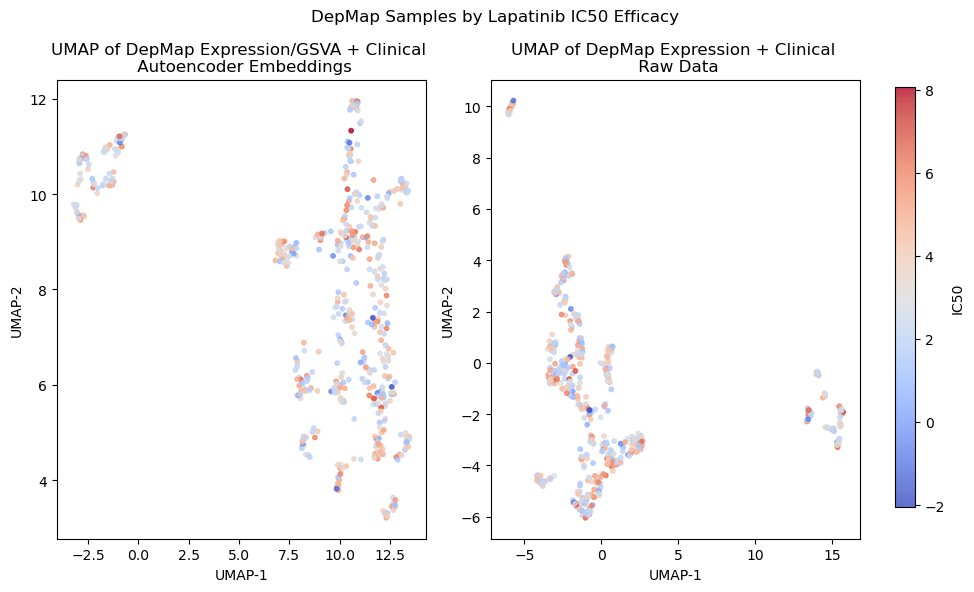

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

c = np.array(lapatinib_mtx['LN_IC50'])

sc0 = axes[0].scatter(emb2d_ae[:,0], emb2d_ae[:,1], s=10, c=c, cmap='coolwarm', alpha=0.8)
axes[0].set_title("UMAP of DepMap Expression/GSVA + Clinical \n Autoencoder Embeddings")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

sc1 = axes[1].scatter(emb2d_raw[:,0], emb2d_raw[:,1], s=10, c=c, cmap='coolwarm', alpha=0.8)
axes[1].set_title("UMAP of DepMap Expression + Clinical \n Raw Data")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Reserve space on the right for a vertical colorbar and avoid overlap with plots
plt.tight_layout(rect=[0, 0, 0.88, 0.95])  # leave space on the right and top for suptitle
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label('IC50')

fig.suptitle("DepMap Samples by Lapatinib IC50 Efficacy", y=0.98)
plt.show()

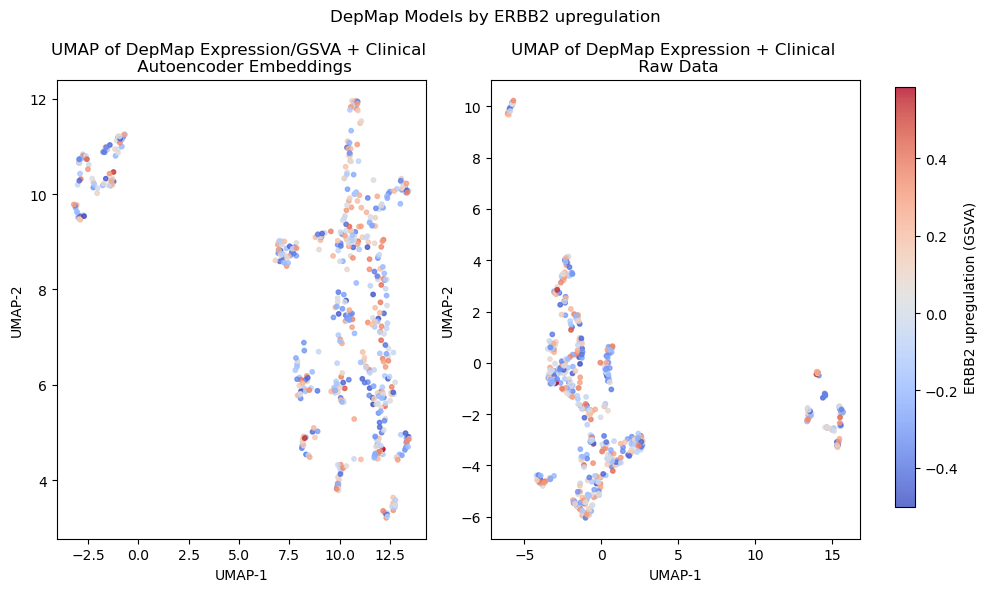

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

c = np.array(gsva_df['ONCOGENIC_ERBB2_UP.V1_UP'])

sc0 = axes[0].scatter(emb2d_ae[:,0], emb2d_ae[:,1], s=10, c=c, cmap='coolwarm', alpha=0.8)
axes[0].set_title("UMAP of DepMap Expression/GSVA + Clinical \n Autoencoder Embeddings")
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

sc1 = axes[1].scatter(emb2d_raw[:,0], emb2d_raw[:,1], s=10, c=c, cmap='coolwarm', alpha=0.8)
axes[1].set_title("UMAP of DepMap Expression + Clinical \n Raw Data")
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Reserve space on the right for a vertical colorbar and avoid overlap with plots
plt.tight_layout(rect=[0, 0, 0.88, 0.95])  # leave space on the right and top for suptitle
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sc1, cax=cax)
cbar.set_label('ERBB2 upregulation (GSVA)')

fig.suptitle("DepMap Models by ERBB2 upregulation", y=0.98)
plt.show()

In [29]:
import xgboost as xgb
import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

def tune_xgb_regressor(X, y, n_iter=50, cv=5, random_state=42):
    xgb_model = xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=-1,
        verbosity=0
    )

    param_distributions = {
        "n_estimators": randint(100, 600),
        "max_depth": randint(2, 6),
        "learning_rate": uniform(0.01, 0.15),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.5, 0.5),
        "min_child_weight": randint(1, 10),
        "gamma": uniform(0, 2.0),
        "reg_alpha": uniform(0.0, 1.0),
        "reg_lambda": uniform(0.5, 2.0),
    }

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        random_state=random_state,
        verbose=1
    )

    search.fit(X, y)

    return search.best_estimator_, search.best_params_, search.best_score_

y = lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug]

X_data_ae = torch.tensor(X_AE_embeddings.values, dtype=torch.float32)
y_data = torch.tensor(y.values, dtype=torch.float32)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data_ae, y_data, test_size=0.25, random_state=101)


best_model, best_params, best_cv_score = tune_xgb_regressor(X_data_ae, y_data)

print("Best CV RMSE:", -best_cv_score)
print("Best parameters:")
for k, v in best_params.items():
    print(f"{k} = {v},")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV RMSE: 1.4153163194656373
Best parameters:
colsample_bytree = 0.8037724259507192,
gamma = 0.34104824737458306,
learning_rate = 0.019757738947791925,
max_depth = 5,
min_child_weight = 9,
n_estimators = 415,
reg_alpha = 0.5632882178455393,
reg_lambda = 1.2708330050798322,
subsample = 0.6063865008880857,


In [30]:
## downstream prediction of lapatinib sensitivity using AE embeddings + clinical data

y = lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug]

X_data_ae = np.asarray(X_AE_embeddings)
y_data = np.asarray(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data_ae, y_data, test_size=0.25, random_state=101)

# initialise and train XGBRegressor
model = xgb.XGBRegressor(
    colsample_bytree = 0.8037724259507192,
    gamma = 0.34104824737458306,
    learning_rate = 0.019757738947791925,
    max_depth = 5,
    min_child_weight = 9,
    n_estimators = 415,
    reg_alpha = 0.5632882178455393,
    reg_lambda = 1.2708330050798322,
    subsample = 0.6063865008880857,
    )
model.fit(X_train, y_train)

# Predictions on test set
y_pred_test = model.predict(X_test)

# Calculate test metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = np.mean(np.abs(y_test - y_pred_test))

print("-" * 60)
print("TEST SET DETAILED RESULTS")
print("-" * 60)
print(f"MSE:   {mse_test:.4f}")
print(f"RMSE:  {rmse_test:.4f}")
print(f"MAE:   {mae_test:.4f}")
print(f"r-squared:    {r2_test:.4f}")
print(f"N samples: {len(y_test)}")

# cross-validation k=5
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_ae_ic50 = cross_validate(
    model, X_data, y_data, cv=cv,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_rmse = np.sqrt(-cv_results_ae_ic50['test_neg_mean_squared_error'])
cv_r2 = cv_results_ae_ic50['test_r2']

print("\n" + "-" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("-" * 60)
print(f"RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
print(f"r-squared:   {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print("\nPer-fold RMSE:", [f"{x:.4f}" for x in cv_rmse])
print("Per-fold r-squared:  ", [f"{x:.4f}" for x in cv_r2])


------------------------------------------------------------
TEST SET DETAILED RESULTS
------------------------------------------------------------
MSE:   2.5906
RMSE:  1.6095
MAE:   1.2909
r-squared:    0.1730
N samples: 141

------------------------------------------------------------
5-FOLD CROSS-VALIDATION RESULTS
------------------------------------------------------------
RMSE: 1.3977 (+/- 0.0958)
r-squared:   0.2611 (+/- 0.0265)

Per-fold RMSE: ['1.3794', '1.3051', '1.4044', '1.3244', '1.5754']
Per-fold r-squared:   ['0.2351', '0.2824', '0.2340', '0.3009', '0.2533']


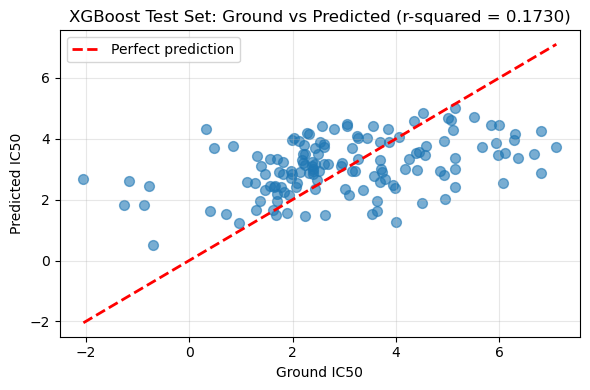

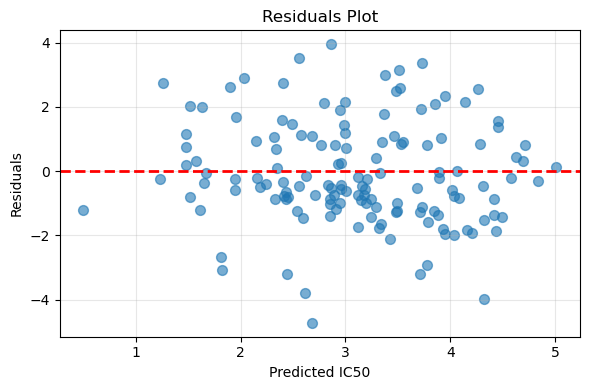

In [31]:

# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Ground IC50')
plt.ylabel('Predicted IC50')
plt.title(f'XGBoost Test Set: Ground vs Predicted (r-squared = {r2_test:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted IC50')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Feature importance
feature_importance_ae_ic50 = pd.DataFrame({
    'feature': X_AE_embeddings.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


- given that the downstream prediction still fails to learn extreme values of IC50 on both (1) high dimensional raw data and (2) dimensionally reduced biologically refined embeddings, I should improve the regressor model by using a non-linear neural network regressor

In [32]:
# IC50Regressor using PyTorch

class IC50Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.25):
        super(IC50Regressor, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hdim
        
        layers.append(nn.Linear(prev_dim, 1))  # output IC50
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).squeeze(1)
    
# MSE loss 
# alpha > 1 increases weight on samples further from mean - which is the case with our IC50 values
class WeightedMSELoss(nn.Module):
    def __init__(self, alpha=2.0):
        """
        alpha > 1 increases weight on extreme values
        """
        super().__init__()
        self.alpha = alpha
        
    def forward(self, preds, targets):
        weights = torch.abs(targets - targets.mean())
        weights = weights / (weights.mean() + 1e-6)
        weights = 1.0 + self.alpha * weights
        return torch.mean(weights * (preds - targets)**2)

# training
def train_nn_regressor(X_train, y_train,
                       X_val=None, y_val=None,
                       epochs=500,
                       lr=1e-3,
                       batch_size=16,
                       weight_decay=1e-5,
                       alpha=2.0):
    
    model = IC50Regressor(X_train.shape[1])
    criterion = WeightedMSELoss(alpha=alpha)
    optimizer = optim.Adam(model.parameters(),
                           lr=lr,
                           weight_decay=weight_decay)
    
    train_ds = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=batch_size, shuffle=True
    )
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if epoch % 50 == 0:
            msg = f"Epoch {epoch:03d} | Train loss = {epoch_loss/len(train_loader):.4f}"
            
            if X_val is not None:
                model.eval()
                with torch.no_grad():
                    val_preds = model(X_val)
                    val_loss = criterion(val_preds, y_val)
                msg += f" | Val loss = {val_loss:.4f}"
            
            print(msg)
    
    return model

In [33]:
# X_data_ae = joint embeddings from autoencoder

y = lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug]

X_data_ae = torch.tensor(X_AE_embeddings.values, dtype=torch.float32)
y_data = torch.tensor(y.values, dtype=torch.float32)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_data_ae, y_data, test_size=0.25, random_state=101)

model = train_nn_regressor(X_train, y_train, epochs=500, alpha=1.2)


Epoch 000 | Train loss = 12.5300
Epoch 050 | Train loss = 1.1939
Epoch 100 | Train loss = 1.1534
Epoch 150 | Train loss = 1.0314
Epoch 200 | Train loss = 0.7369
Epoch 250 | Train loss = 0.6097
Epoch 300 | Train loss = 0.5115
Epoch 350 | Train loss = 0.4824
Epoch 400 | Train loss = 0.4748
Epoch 450 | Train loss = 0.3710


In [34]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).numpy()
y_test = y_test.numpy()

In [35]:
# Calculate test metrics

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = np.mean(np.abs(y_test - y_pred_test))

print("-" * 60)
print("TEST SET DETAILED RESULTS")
print("-" * 60)
print(f"MSE:   {mse_test:.4f}")
print(f"RMSE:  {rmse_test:.4f}")
print(f"MAE:   {mae_test:.4f}")
print(f"r-squared:    {r2_test:.4f}")
print(f"N samples: {len(y_test)}")


------------------------------------------------------------
TEST SET DETAILED RESULTS
------------------------------------------------------------
MSE:   3.1062
RMSE:  1.7624
MAE:   1.3837
r-squared:    0.0084
N samples: 141


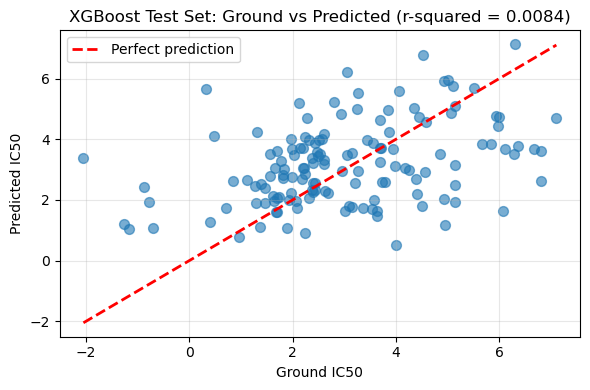

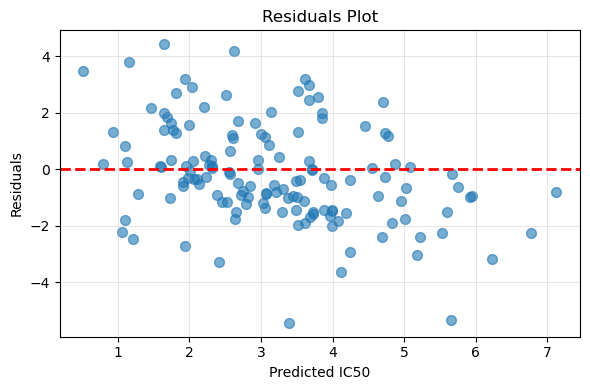

In [36]:
# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Ground IC50')
plt.ylabel('Predicted IC50')
plt.title(f'XGBoost Test Set: Ground vs Predicted (r-squared = {r2_test:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted IC50')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Using 421 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/141 [00:00<?, ?it/s]

<Axes: ylabel='index'>

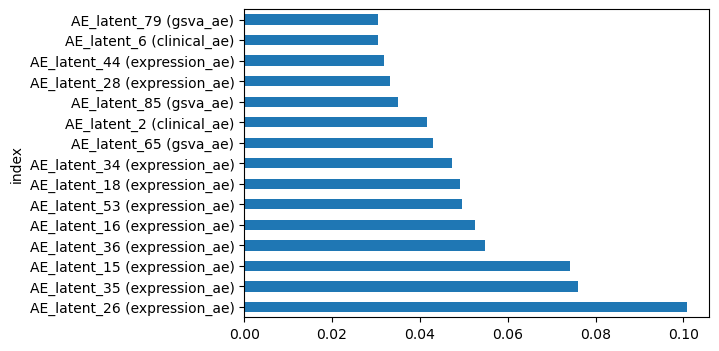

In [37]:
import shap

def model_predict(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        return model(x_torch).cpu().numpy()

background = X_train[:].cpu().numpy()
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test.cpu().numpy(), nsamples=100)

shap_values = pd.DataFrame(shap_values, columns=X_AE_embeddings.columns).abs().mean().sort_values(ascending=False).reset_index()
shap_values['idx'] = shap_values['index'].apply(lambda x:int(x.split('_')[-1].strip('')))
shap_values.loc[shap_values['idx'] < 8, 'type'] = 'clinical_ae'
shap_values.loc[(shap_values['idx'] >= 8) & (shap_values['idx'] < 64), 'type'] = 'expression_ae'
shap_values.loc[(shap_values['idx'] >= 64) & (shap_values['idx'] < 88), 'type'] = 'gsva_ae'
shap_values['index'] = shap_values['index'] + ' (' + shap_values['type'] + ')'
shap_values.set_index('index', inplace=True)

shap_values.loc[(shap_values[0] > 0), 0].sort_values(ascending=False).head(15).plot.barh(figsize=(6,4))


In [38]:
feature_importance_ae_ic50

,feature,importance
26,AE_latent_26,0.041229
9,AE_latent_9,0.032773
1,AE_latent_1,0.026866
16,AE_latent_16,0.022993
44,AE_latent_44,0.022920
...,...,...
3,AE_latent_3,0.006597
7,AE_latent_7,0.006481
70,AE_latent_70,0.006413
4,AE_latent_4,0.006099


<Axes: ylabel='feature'>

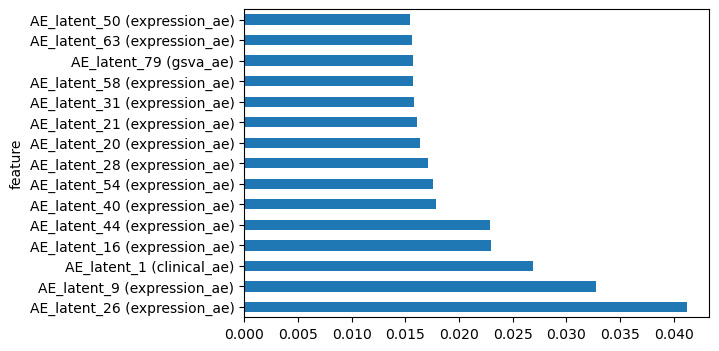

In [39]:
feature_importance_ae_ic50.head(15).plot.barh(x='feature', y='importance', legend=False)

feature_importance_ae_ic50['idx'] = feature_importance_ae_ic50['feature'].apply(lambda x:int(x.split('_')[-1].strip('')))
feature_importance_ae_ic50.loc[feature_importance_ae_ic50['idx'] < 8, 'type'] = 'clinical_ae'
feature_importance_ae_ic50.loc[(feature_importance_ae_ic50['idx'] >= 8) & (feature_importance_ae_ic50['idx'] < 64), 'type'] = 'expression_ae'
feature_importance_ae_ic50.loc[(feature_importance_ae_ic50['idx'] >= 64) & (feature_importance_ae_ic50['idx'] < 88), 'type'] = 'gsva_ae'
feature_importance_ae_ic50['feature'] = feature_importance_ae_ic50['feature'] + ' (' + feature_importance_ae_ic50['type'] + ')'
feature_importance_ae_ic50.set_index('feature', inplace=True)

feature_importance_ae_ic50.loc[(feature_importance_ae_ic50['importance'] > 0), 'importance'].sort_values(ascending=False).head(15).plot.barh(figsize=(6,4))


- the predictive power has slightly improved however there is not great interpretability here - reverting to an XGBoost Classifier with precise biological features to observe if feature selection can predict efficacy better

In [40]:
# feature selection
 
# gene_features = list(set(gene_features + msigdb_genes).intersection(expression_df.columns))
refined_gene_features = list(set(gene_features) & set(correlated_genes)  & set(msigdb_genes)) # | (set(msigdb_genes).intersection(set(expression_df.columns))))

expression_mtx = expression_df.loc[sample_ids_w_drug, refined_gene_features]
# umap_exp_emb = umap.UMAP(n_components=32, random_state=42).fit_transform(expression_mtx)



In [41]:
# Model 3: prediction of lapatinib sensitivity using GSVA + clinical data

y = lapatinib_mtx['LN_IC50'].loc[sample_ids_w_drug]

lapatinib_relevant_pathways = [
    "HALLMARK_EGF_RESPONSE","HALLMARK_PI3K_AKT_MTOR_SIGNALING","HALLMARK_MTORC1_SIGNALING",
    "HALLMARK_KRAS_SIGNALING_UP","HALLMARK_MAPK_SIGNALING", "HALLMARK_MYC_TARGETS_V1", "HALLMARK_MYC_TARGETS_V2","HALLMARK_E2F_TARGETS", 
    "HALLMARK_G2M_CHECKPOINT", "ONCOGENIC_EGFR_UP.V1_UP","ONCOGENIC_ERBB2_UP.V1_UP", "ONCOGENIC_KRAS.600_UP.V1_UP", "ONCOGENIC_PI3K_AKT_MTOR_UP.V1_UP", 
    "ONCOGENIC_MYC_UP.V1_UP", "ONCOGENIC_AKT_UP.V1_UP"
]

gsva_mtx = gsva_df.loc[sample_ids_w_drug]
gsva_mtx = gsva_mtx.loc[:, gsva_mtx.columns.isin(correlated_pathways + lapatinib_relevant_pathways)]

X_gsva_clin = pd.concat([clinical_mtx2, gsva_mtx], axis=1)
y_data = np.asarray(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_gsva_clin, y_data, test_size=0.25, random_state=101)

# initialise and train XGBRegressor
model = xgb.XGBRegressor(
    colsample_bytree = 0.5,
    gamma = 1,
    learning_rate = 0.01,
    max_depth = 3,
    min_child_weight = 2,
    n_estimators = 300,
    reg_alpha = 0.5,
    reg_lambda = 1.5,
    subsample = 0.8,
    )
model.fit(X_train, y_train)

# Predictions on test set
y_pred_test = model.predict(X_test)

# Calculate test metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = np.mean(np.abs(y_test - y_pred_test))

print("-" * 60)
print("TEST SET DETAILED RESULTS")
print("-" * 60)
print(f"MSE:   {mse_test:.4f}")
print(f"RMSE:  {rmse_test:.4f}")
print(f"MAE:   {mae_test:.4f}")
print(f"r-squared:    {r2_test:.4f}")
print(f"N samples: {len(y_test)}")

# cross-validation k=5
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_umap_ic50 = cross_validate(
    model, X_data, y_data, cv=cv,
    scoring=['neg_mean_squared_error', 'r2'],
    return_train_score=True
)

cv_rmse = np.sqrt(-cv_results_umap_ic50['test_neg_mean_squared_error'])
cv_r2 = cv_results_umap_ic50['test_r2']

print("\n" + "-" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("-" * 60)
print(f"RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
print(f"r-squared:   {cv_r2.mean():.4f} (+/- {cv_r2.std():.4f})")
print("\nPer-fold RMSE:", [f"{x:.4f}" for x in cv_rmse])
print("Per-fold r-squared:  ", [f"{x:.4f}" for x in cv_r2])

------------------------------------------------------------
TEST SET DETAILED RESULTS
------------------------------------------------------------
MSE:   3.0724
RMSE:  1.7528
MAE:   1.3812
r-squared:    0.0192
N samples: 141

------------------------------------------------------------
5-FOLD CROSS-VALIDATION RESULTS
------------------------------------------------------------
RMSE: 1.4352 (+/- 0.0828)
r-squared:   0.2200 (+/- 0.0279)

Per-fold RMSE: ['1.4149', '1.3581', '1.4509', '1.3659', '1.5863']
Per-fold r-squared:   ['0.1952', '0.2230', '0.1824', '0.2564', '0.2429']


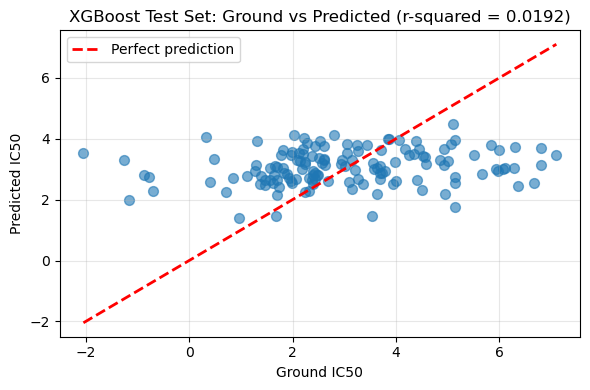

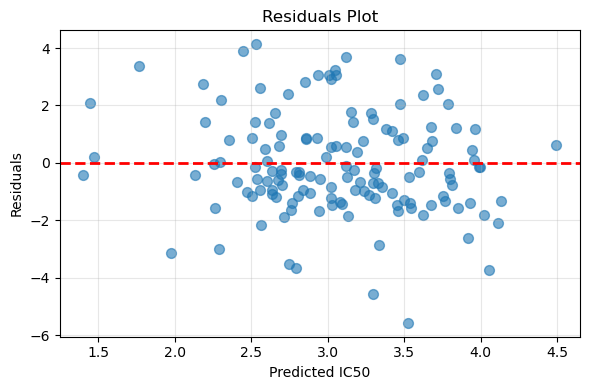

In [42]:
# Plot actual vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Ground IC50')
plt.ylabel('Predicted IC50')
plt.title(f'XGBoost Test Set: Ground vs Predicted (r-squared = {r2_test:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = y_test - y_pred_test
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted IC50')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# # Feature importance
feature_importance_gsva_ic50 = pd.DataFrame({
    'feature': X_gsva_clin.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


## Biological Interpretability

In [43]:
gene_to_hallmark_pathways = {gene: [pathway for pathway, genes in msigdb_hallmark.items() if gene in genes] 
                    for gene in set(g for genes in msigdb_hallmark.values() for g in genes)}

gene_to_oncogenic_pathways = {gene: [pathway for pathway, genes in msigdb_oncogenic.items() if gene in genes] 
                    for gene in set(g for genes in msigdb_oncogenic.values() for g in genes)}

combined_gene_pathways = gene_to_hallmark_pathways.copy()
combined_gene_pathways.update(gene_to_oncogenic_pathways)

feature_importance_ic50['pathway'] = feature_importance_ic50['feature'].map(combined_gene_pathways)
feature_importance_ic50.sort_values('importance', ascending=False, inplace=True)
feature_importance_ic50['rank'] = range(1, len(feature_importance_ic50) + 1)

feature_importance_ic50.loc[feature_importance_ic50['feature'].isin(msigdb_oncogenic['ERBB2_UP.V1_UP']) |
                            feature_importance_ic50['feature'].isin(msigdb_oncogenic['EGFR_UP.V1_UP']), 'relevant_biology'] = 'EGFR/ERBB2 signaling'
feature_importance_ic50.loc[feature_importance_ic50['feature'].str.contains('AKT|MTOR|RAS|PI3K|MAPK|MYC'), 'relevant_biology'] = 'other signaling pathways'
feature_importance_ic50['relevant_biology'].fillna('other', inplace=True)

/var/folders/_4/9nrs715j24b57wtj2r5vhzz80000gn/T/ipykernel_81853/1711989661.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feature_importance_ic50['relevant_biology'].fillna('other', inplace=True)


In [44]:
feature_importance_ic50.head(50)

,feature,importance,pathway,rank,relevant_biology
1465,CAMK1,0.005296,"[P53_DN.V1_UP, KRAS.AMP.LUNG_UP.V1_DN, KRAS.BR...",1,other
2176,CFL2,0.004929,"[STK33_NOMO_UP, STK33_SKM_UP, STK33_UP]",2,other
2566,CALU,0.004514,[NRL_DN.V1_UP],3,other
2037,FGD3,0.004193,NaN,4,other
713,TGFB1I1,0.003712,"[E2F1_UP.V1_DN, MEK_UP.V1_UP, ESC_V6.5_UP_EARL...",5,other
1361,NRSN2,0.003624,"[CAMP_UP.V1_UP, TGFB_UP.V1_DN]",6,other
1484,ETV1,0.003442,"[STK33_SKM_UP, ALK_DN.V1_UP, BMI1_DN.V1_DN, KR...",7,other
519,DCBLD2,0.003403,"[KRAS.300_UP.V1_UP, KRAS.600_UP.V1_UP, KRAS.60...",8,other
1317,SNAP25,0.003313,"[RB_DN.V1_UP, KRAS.300_UP.V1_UP, KRAS.50_UP.V1...",9,other
2219,SEMA4A,0.003265,NaN,10,other


In [45]:
feature_importance_gsva_ic50.sort_values('importance', ascending=False, inplace=True)
feature_importance_gsva_ic50['rank'] = range(1, len(feature_importance_gsva_ic50) + 1)
feature_importance_gsva_ic50.head(50)

,feature,importance,rank
70,ONCOGENIC_CORDENONSI_YAP_CONSERVED_SIGNATURE,0.020323,1
88,ONCOGENIC_KRAS.50_UP.V1_DN,0.017577,2
127,ONCOGENIC_TBK1.DF_UP,0.017235,3
10,lineage_breast,0.015188,4
110,ONCOGENIC_PRC1_BMI_UP.V1_UP,0.014912,5
105,ONCOGENIC_NRL_DN.V1_UP,0.014257,6
100,ONCOGENIC_KRAS.LUNG_UP.V1_DN,0.013591,7
103,ONCOGENIC_MTOR_UP.V1_UP,0.013527,8
61,ONCOGENIC_ALK_DN.V1_DN,0.013238,9
79,ONCOGENIC_E2F3_UP.V1_DN,0.013039,10
